# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
import graphviz
import pydot_ng as pydot
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup
from math import floor


In [3]:
import pandas as pd
global df
df = pd.read_csv('hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


In [4]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [5]:
from keras import backend as K
from math import sqrt 
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))


In [6]:
def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Question 1

In [7]:
# Split data

train_dataframe = df[df['year']<= 2020] 
test_dataframe =  df[df['year']>2020]

In [8]:
train_dataframe.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [9]:
global train_dataframe
global test_dataframe

category_not_used = ["full_address", "nearest_stn"]
train_dataframe = train_dataframe.drop(category_not_used, axis = 1)
test_dataframe = test_dataframe.drop(category_not_used, axis = 1)

train_ds = dataframe_to_dataset(train_dataframe)
test_ds = dataframe_to_dataset(test_dataframe)

train_ds = train_ds.batch(256)
test_ds = test_ds.batch(256)

## Question 1A 
#### Why is this done instead of using random train/test split?

**The rationale to predict resale prices is to used past data as the training dataset to predict future values. Hence the training dataset are used for year <= 2020**


## Question 1B 

In [10]:
global month, storey_range, flat_model_type, floor_area_sqm, remaining_lease_years, degree_centrality, eigenvector_centrality, dist_to_nearest_stn, dist_to_dhoby
global month_encoded, storey_range_encoded, flat_model_type_encoded, floor_area_sqm_encoded, remaining_lease_year_encoded, degree_centrality_encoded, eigenvector_centrality_encoded, dist_to_nearest_stn_encoded, dist_to_dhoby_encoded

In [11]:
#Categorical feature encoded as integer
month = keras.Input(shape=(1,), name="month", dtype="int64")

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
#resale_price = keras.Input(shape=(1,), name="resale_price")

all_inputs = [month,flat_model_type,storey_range,dist_to_nearest_stn,
            dist_to_dhoby,degree_centrality,eigenvector_centrality,remaining_lease_years,floor_area_sqm]


#Integer categorical features
month_encoded = encode_categorical_feature(month, "month",train_ds, False)

#String categorical features
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type",train_ds, True)
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range",train_ds, True)

#Numerical features
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_year_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm,"floor_area_sqm", train_ds)

all_features = layers.Concatenate()(
                [
                    month_encoded,
                    storey_range_encoded,
                    flat_model_type_encoded,
                    floor_area_sqm_encoded,
                    remaining_lease_year_encoded,
                    degree_centrality_encoded,
                    eigenvector_centrality_encoded,
                    dist_to_nearest_stn_encoded,
                    dist_to_dhoby_encoded
                ]
)
output = layers.Dense(1, activation="linear")(all_features)
adam_model = keras.Model(all_inputs, output)
adam_model.compile(optimizer="adam", loss= "mse",metrics=[r2])


#### **ARCHITECTURE**

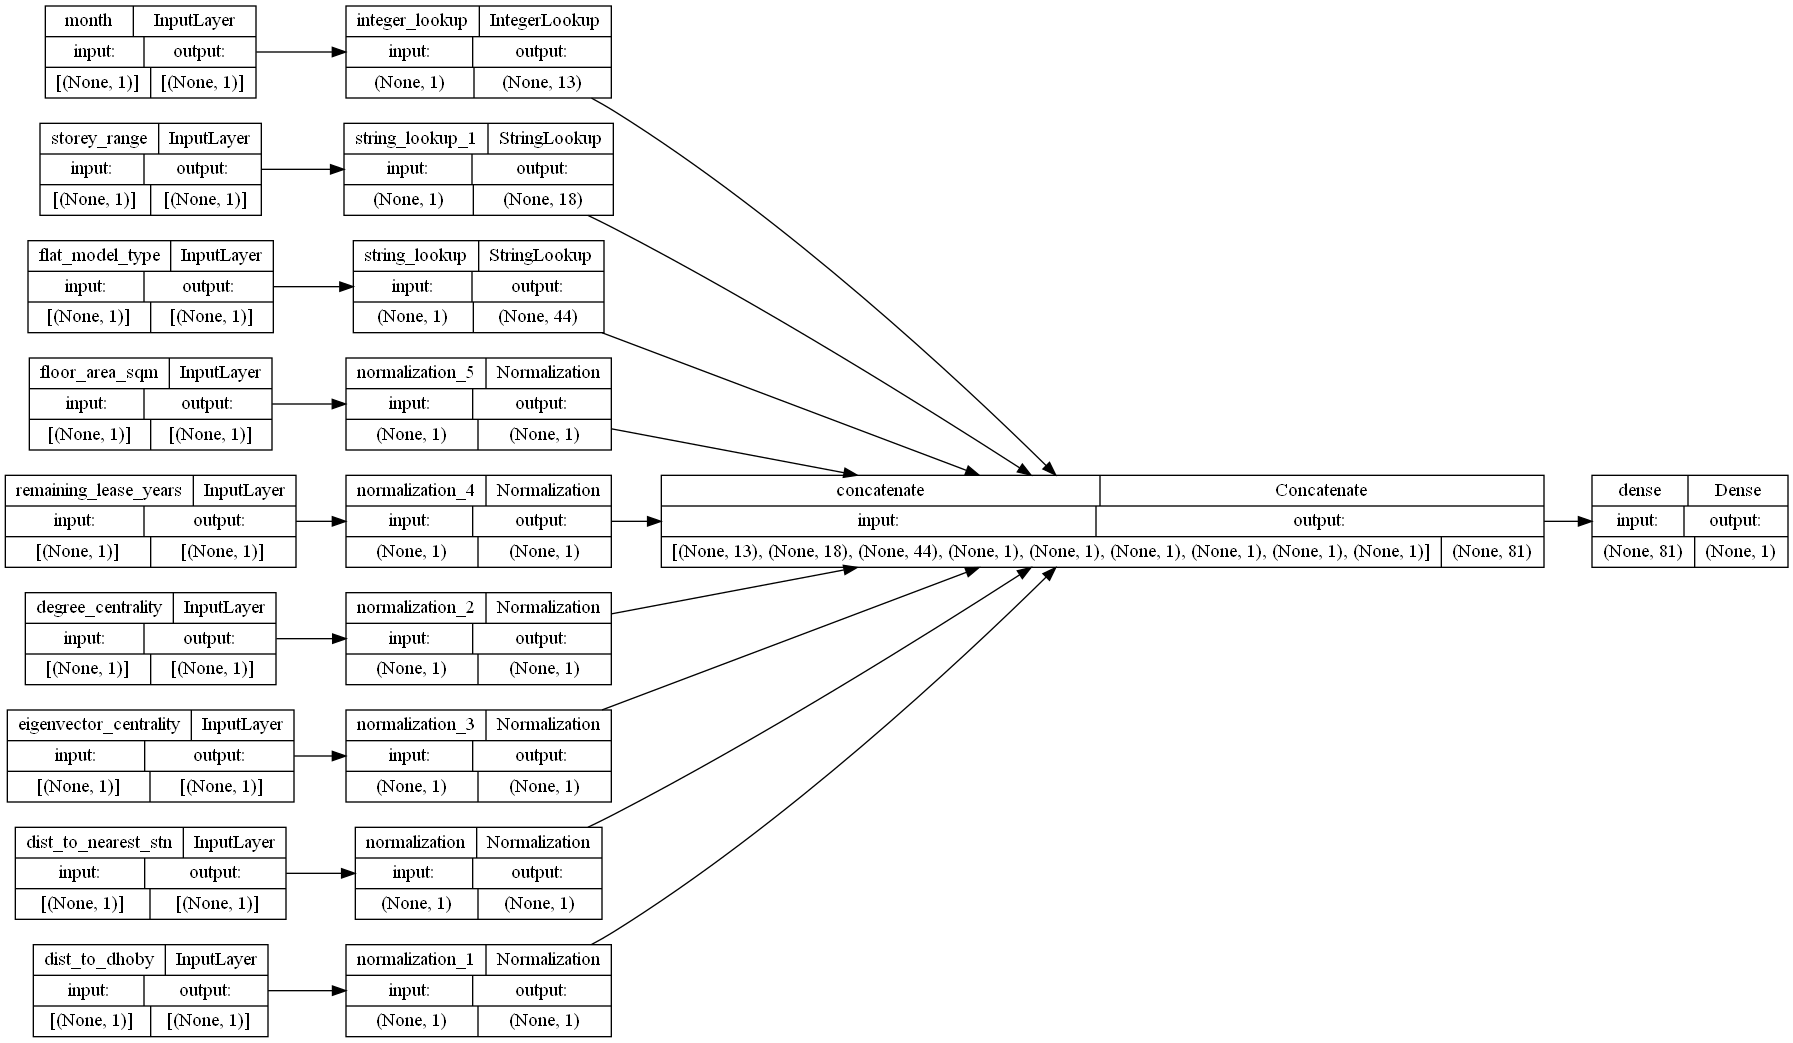

In [12]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(adam_model, show_shapes=True, rankdir="LR")

## Question 1C
#### Training **Adam** model and **SGD** model 

In [13]:
history = {}
no_epochs = 50
batch_size = 256
history["adam_model"] = adam_model.fit(train_ds, epochs=no_epochs,batch_size=batch_size, validation_data=test_ds, verbose=0)

c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


#### Training of **SGD model** with learning rate **0.01**

In [14]:
custom_optimizer=tf.keras.optimizers.SGD(learning_rate=0.01)
sgd_model = keras.Model(all_inputs, output)
sgd_model.compile(optimizer=custom_optimizer, loss="mse", metrics=[r2])
history["sgd_model"] = sgd_model.fit(train_ds, epochs=no_epochs,batch_size=batch_size, validation_data=test_ds, verbose=0)

In [15]:
data = {"Q1C_Adam_Train R^2": [history["adam_model"].history["r2"][-1]],
        "Q1C_Adam_Val R^2": [history["adam_model"].history["val_r2"][-1]],
        "SGD_Train R^2": [history["sgd_model"].history["r2"][-1]],
        "SGD_Val R^2": [history["sgd_model"].history["val_r2"][-1]]
       }
data_df = pd.DataFrame.from_dict(data)
data_df

,Q1C_Adam_Train R^2,Q1C_Adam_Val R^2,SGD_Train R^2,SGD_Val R^2
0,-8.350128,-10.07388,0.840261,0.610094


#### Report why the change to SGD fixes the problem faced when using Adam optimiser

**Adam algorithm is lecerages on the power of adaptive learning rates methods to find individual learning rates for each parameter. Due to the low learning rate of the Adam optimiser, it is very likely that it does not have sufficient iteration time to converge to the optimal..**

## Question 1D 
#### Training of **Adam** model with learning rate of **0.08**

In [16]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.08)
hidden_layer = layers.Dense(10, activation ="linear")(all_features)
Q1D_output = layers.Dense(1, activation="linear")(hidden_layer)
Q1D_adam_model = keras.Model(all_inputs, Q1D_output)
Q1D_adam_model.compile(optimizer=adam_optimizer, loss= "mse",metrics=[r2])

In [17]:
history["Q1D_adam_model"] = Q1D_adam_model.fit(train_ds, epochs=no_epochs,batch_size=batch_size, validation_data=test_ds, verbose=0)

c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


## Question 1E 


In [18]:
# Compare with a table and explain
Q1_data = {"Q1D_Adam_Train R^2": [history["Q1D_adam_model"].history["r2"][-1]],
        "Q1D_Adam_Val R^2": [history["Q1D_adam_model"].history["val_r2"][-1]],
        "Q1C_Adam_Train R^2": [history["adam_model"].history["r2"][-1]],
        "Q1C_Adam_Val R^2": [history["adam_model"].history["val_r2"][-1]],
        "SGD_Train R^2": [history["sgd_model"].history["r2"][-1]],
        "SGD_Val R^2": [history["sgd_model"].history["val_r2"][-1]]
        }


data_df = pd.DataFrame.from_dict(Q1_data)
data_df

,Q1D_Adam_Train R^2,Q1D_Adam_Val R^2,Q1C_Adam_Train R^2,Q1C_Adam_Val R^2,SGD_Train R^2,SGD_Val R^2
0,0.845678,0.628727,-8.350128,-10.07388,0.840261,0.610094


#### Compare the performance of 1C and 1D and suggest reasons for the observations
**PLEASE ANSWER**

## Question 2

## Question 2A

In [19]:
Q2_validation_dataframe = train_dataframe[train_dataframe["year"]==2020]
Q2_train_dataframe = train_dataframe[train_dataframe["year"]<2020]


In [20]:
global Q2_train_ds
global Q2_val_ds

Q2_train_ds = dataframe_to_dataset(Q2_train_dataframe)
Q2_val_ds = dataframe_to_dataset(Q2_validation_dataframe)

Q2_train_ds = Q2_train_ds.batch(256)
Q2_val_ds = Q2_val_ds.batch(256)

## Question 2B

In [22]:
def Q2_encode_categorical_feature(feature, name, dataset, is_string, num_categories, divisor):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x,-1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)

    emb = layers.Embedding(input_dim=num_categories+1, output_dim=floor(num_categories//divisor))
    embedded = emb(encoded_feature)

    return layers.Flatten()(embedded)


## Question 2C

In [23]:
global callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


In [24]:
# Numerical features
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", Q2_train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", Q2_train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", Q2_train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", Q2_train_ds)
remaining_lease_year_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", Q2_train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm,"floor_area_sqm", Q2_train_ds)

In [25]:
import keras_tuner

def build_model(hp):
    global Q2_output
    global Q2_optimizer
    global divisor
    global hidden_units
    
    Q2_optimizer = tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 2e-1, sampling='log'))
    divisor = hp.Int("divisor", min_value=1, max_value=2, step=1)

    hidden_units = hp.Int("hidden_units", min_value=4, max_value=32, step=4)
    

    month_num_categories = df["month"].nunique()
    flat_model_type_num_categories = df["flat_model_type"].nunique()
    storey_range_num_categories = df["storey_range"].nunique()


    #Integer categorical features
    month_embedded = Q2_encode_categorical_feature(month, "month",Q2_train_ds, False, month_num_categories, divisor)
    #String categorical features
    flat_model_type_embedded = Q2_encode_categorical_feature(flat_model_type, "flat_model_type",Q2_train_ds, True, flat_model_type_num_categories, divisor)
    storey_range_embedded = Q2_encode_categorical_feature(storey_range, "storey_range",Q2_train_ds, True, storey_range_num_categories, divisor)
    
    Q2_all_features = layers.Concatenate()(
                    [
                        month_embedded,
                        storey_range_embedded,
                        flat_model_type_embedded,
                        floor_area_sqm_encoded,
                        remaining_lease_year_encoded,
                        degree_centrality_encoded,
                        eigenvector_centrality_encoded,
                        dist_to_nearest_stn_encoded,
                        dist_to_dhoby_encoded
                    ]
        )
    hidden_layer = layers.Dense(units=hidden_units, activation ="linear")(Q2_all_features)
    Q2_output = layers.Dense(1, activation="linear")(hidden_layer)
    Q2_model = keras.Model(all_inputs, Q2_output)
    Q2_model.compile(optimizer=Q2_optimizer, loss= "mse",metrics=[r2])

    return Q2_model
    


In [26]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10)

# Use Q2_train_ds or train_ds? Assume use Q2_train_ds first
tuner.search(Q2_train_ds, epochs=50, validation_data=Q2_val_ds, callbacks=[callback])
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [27]:
best_hyperparameters.values

{'learning_rate': 0.07341006871139777, 'divisor': 2, 'hidden_units': 12}

## Question 2D 
**Training of model based on best model configuration and test RMSE** 

In [28]:
global Q2_best_model
Q2_best_model_history = {}
Q2_best_model = build_model(best_hyperparameters)

# Train on the non-test split ( 2020 and before hence using train_ds instead of Q2_train_ds)
Q2_best_model_history["best_model"] = Q2_best_model.fit(train_ds, epochs=50, validation_data = Q2_val_ds, verbose=0)

c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [29]:
def square_roots(l):
    result = [sqrt(i) for i in l]
    return result

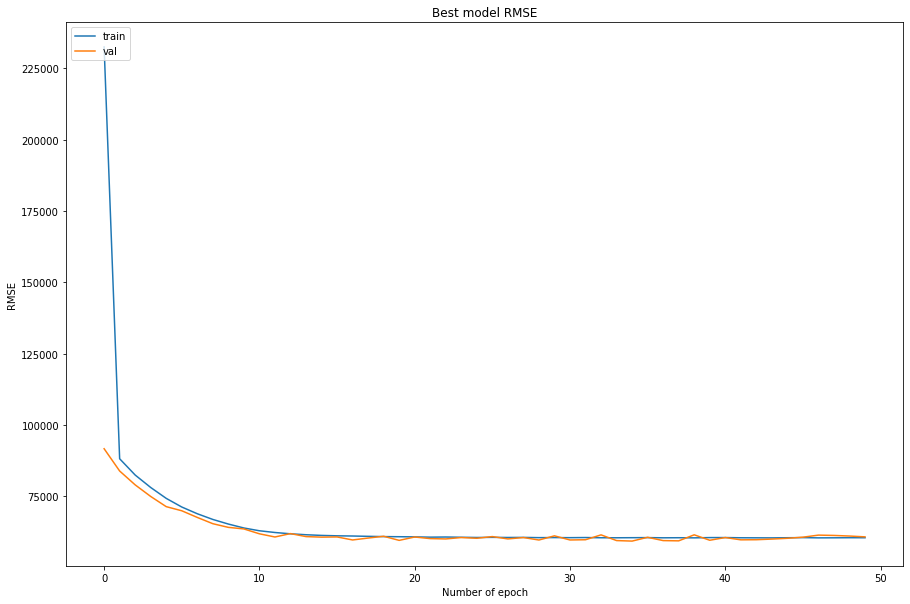

In [30]:
import matplotlib.pyplot as plt
plt_1 = plt.figure(figsize=(15, 10))
# Plot 
plt.plot(square_roots(Q2_best_model_history['best_model'].history['loss'][0:]))
plt.plot(square_roots(Q2_best_model_history['best_model'].history['val_loss'][0:]))
plt.title('Best model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Number of epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

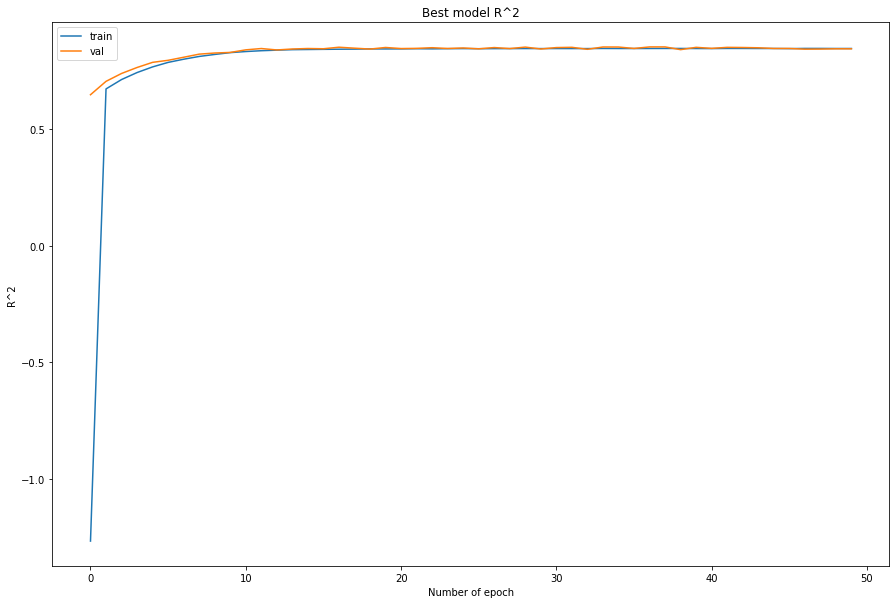

In [31]:
import matplotlib.pyplot as plt
plt_1 = plt.figure(figsize=(15, 10))
# Plot from the 6th epoch
plt.plot(Q2_best_model_history['best_model'].history['r2'][0:])
plt.plot(Q2_best_model_history['best_model'].history['val_r2'][0:])
plt.title('Best model R^2')
plt.ylabel('R^2')
plt.xlabel('Number of epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig('figures/1a_accuracy.png')
plt.show()

In [32]:

# Change it into a table
data = {"Train R^2": [Q2_best_model_history["best_model"].history["r2"][-1]],
        "Val R^2": [Q2_best_model_history["best_model"].history["val_r2"][-1]]}

R2_df = pd.DataFrame.from_dict(data)
R2_df

,Train R^2,Val R^2
0,0.844335,0.842905


## Question 2E

In [33]:
# Do a prediction on test set and look for error against predicted - actual


def flatten(l):
    return [item for sublist in l for item in sublist]

def df_to_dataset(dataframe):
    dataframe = dataframe.copy()
    
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    return ds

Q2E_test_df = test_dataframe.copy()
Q2E_test_ds = df_to_dataset(Q2E_test_df)
Q2E_test_ds = Q2E_test_ds.batch(256)

prediction =  Q2_best_model.predict(Q2E_test_ds)
prediction = flatten(prediction)
data_df = test_dataframe.copy()
data_df["Predicted Resale Value"] = prediction

data_df["Error"] = abs(data_df["resale_price"] - data_df["Predicted Resale Value"])
data_df = data_df.sort_values(by="Error", ascending=False)
data_df.head(30)


 13/180 [=>............................] - ETA: 0s 

c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


180/180 [==============================] - 1s 4ms/step


,month,year,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price,Predicted Resale Value,Error
119399,5,2022,0.586629,2.932814,0.016807,0.047782,"5 ROOM, Improved",96.083333,113.0,40 TO 42,1400000.0,899405.12500,500594.87500
127227,8,2022,0.489478,3.977493,0.016807,0.008342,"5 ROOM, Premium Apartment",93.083333,104.0,13 TO 15,1181000.0,681455.50000,499544.50000
114504,12,2021,0.428356,8.948410,0.016807,0.001358,"EXECUTIVE, Maisonette",66.666667,154.0,04 TO 06,1238000.0,746112.62500,491887.37500
120164,1,2022,0.271583,9.003026,0.016807,0.001358,"EXECUTIVE, Maisonette",65.666667,146.0,07 TO 09,1202000.0,721384.81250,480615.18750
119400,5,2022,0.586629,2.932814,0.016807,0.047782,"5 ROOM, Improved",96.083333,113.0,46 TO 48,1380000.0,901255.18750,478744.81250
114505,12,2021,0.473544,8.936025,0.016807,0.001358,"EXECUTIVE, Apartment",66.750000,142.0,04 TO 06,1125000.0,658710.81250,466289.18750
121586,4,2022,0.245502,9.313260,0.016807,0.001179,"5 ROOM, Improved",95.333333,112.0,22 TO 24,1188000.0,724470.56250,463529.43750
117107,7,2022,1.216557,8.071776,0.016807,0.006243,"EXECUTIVE, Apartment",72.833333,146.0,04 TO 06,1120000.0,662227.56250,457772.43750
120166,3,2022,0.271583,9.003026,0.016807,0.001358,"EXECUTIVE, Maisonette",65.500000,146.0,13 TO 15,1198000.0,740317.75000,457682.25000
117058,6,2022,1.722450,7.861222,0.016807,0.006243,"5 ROOM, Improved",95.083333,113.0,19 TO 21,1100000.0,648180.93750,451819.06250


#### List down the trends

**Since the best model was train using train_ds, I will be using test_ds for the model's prediciton. From the model's prediction, we can see that the largest error mainly comes from high value HDB apartment (5 room or better).**

## Question 3

In [34]:
# old test set
Q3_old_df = pd.read_csv('hdb_price_prediction_old.csv')

Q3_old_test_df = Q3_old_df[Q3_old_df["year"]>2020].copy()
Q3_old_test_df = Q3_old_test_df.drop(category_not_used, axis = 1)
Q3_old_test_ds = dataframe_to_dataset(Q3_old_test_df)
Q3_old_test_ds = Q3_old_test_ds.batch(128)

# new test set
Q3_new_test_2021_df = test_dataframe[test_dataframe["year"]==2021].copy()
Q3_new_test_2022_df = test_dataframe[test_dataframe["year"]==2022].copy()

Q3_new_test_2021_ds = dataframe_to_dataset(Q3_new_test_2021_df)
Q3_new_test_2022_ds = dataframe_to_dataset(Q3_new_test_2022_df)

Q3_new_test_2021_ds = Q3_new_test_2021_ds.batch(256)
Q3_new_test_2022_ds = Q3_new_test_2022_ds.batch(256)


In [35]:
old_test_loss, old_test_R2 = Q2_best_model.evaluate(Q3_old_test_ds)
print('Old Test RMSE: %f' % sqrt(old_test_loss))
print('Old Test R^2: %f' % old_test_R2)

new_test_2021_loss, new_test_2021_R2 = Q2_best_model.evaluate(Q3_new_test_2021_ds)
print('Test RMSE_2021: %f' % sqrt(new_test_2021_loss))
print('Test R^2_2021: %f' % (new_test_2021_R2))

new_test_2022_loss, new_test_2022_R2 = Q2_best_model.evaluate(Q3_new_test_2022_ds)
print('Test RMSE_2022: %f' % sqrt(new_test_2022_loss))
print('Test R^2_2022: %f' % (new_test_2022_R2))

#Output in a table

data = {"Old Test RMSE": [sqrt(old_test_loss)],
        "Old Test R^2": [(old_test_R2)],
        "Test RMSE_2021": [sqrt(new_test_2021_loss)],
        "Test R^2_2021": [(new_test_2021_R2)],
        "Test RMSE_2022": [(new_test_2022_loss)],
        "Test R^2_2022": [(new_test_2022_R2)]}

data_df = pd.DataFrame.from_dict(data)
data_df

131/131 [==============================] - 1s 4ms/step - loss: 6623624704.0000 - r2: 0.7424
Old Test RMSE: 81385.654166
Old Test R^2: 0.742431
114/114 [==============================] - 1s 10ms/step - loss: 7844841472.0000 - r2: 0.7000
Test RMSE_2021: 88571.109692
Test R^2_2021: 0.700047
67/67 [==============================] - 0s 5ms/step - loss: 16459223040.0000 - r2: 0.4197
Test RMSE_2022: 128293.503499
Test R^2_2022: 0.419732


,Old Test RMSE,Old Test R^2,Test RMSE_2021,Test R^2_2021,Test RMSE_2022,Test R^2_2022
0,81385.654166,0.742431,88571.109692,0.700047,1.645922e+10,0.419732


## Question 3B 
#### Compare the extent to which model degradation has impacted your model to that of the team's linear regression model and explain why this has occured.

**Model degradation has led to** 


## Question 3C

#### Identifying Covariate shift 

In [36]:
# As we used train_ds for best_model, we are going to use train_dataframe

train_df_shift = train_dataframe.copy()
Q3_old_test_df_shift = Q3_old_test_df.copy()
test_df_2021_shift = Q3_new_test_2021_df.copy()
test_df_2022_shift = Q3_new_test_2022_df.copy()

In [37]:
train_df_shift.head()

,month,year,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


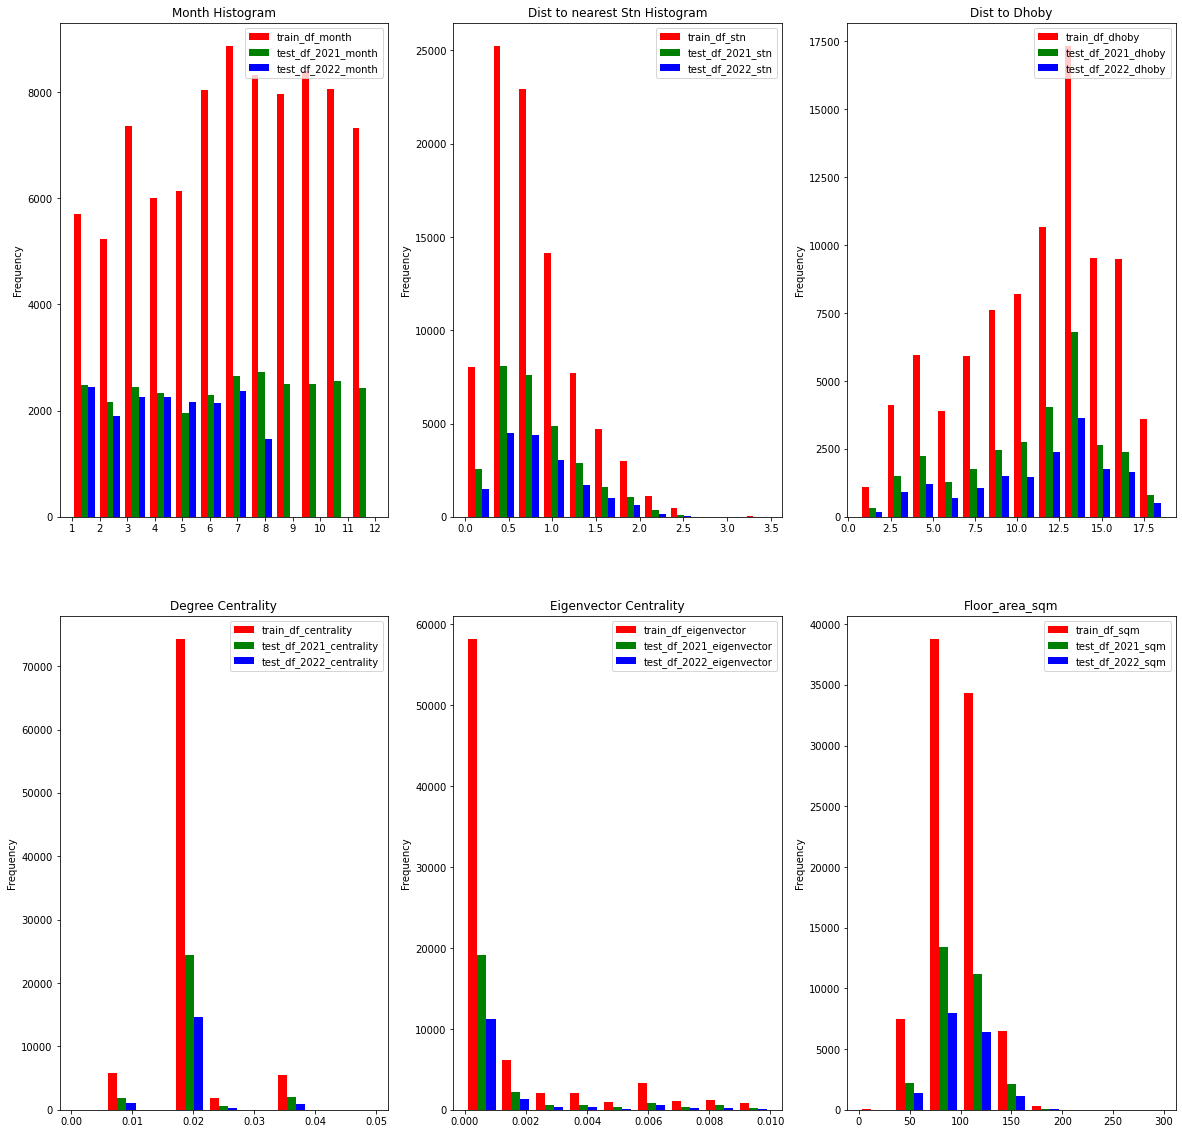

In [38]:
fig, axes =plt.subplots(2,3, figsize=(20,20))
axes[0][0].hist([train_df_shift["month"], test_df_2021_shift["month"],test_df_2022_shift["month"]],bins = 12, histtype='bar', color =['red', 'green', 'blue'], label=['train_df_month', 'test_df_2021_month', 'test_df_2022_month'],rwidth=0.8)
axes[0][0].legend(loc='upper right')
axes[0][0].set_title('Month Histogram')
axes[0][0].set_xticks(range(1,13))
axes[0][0].set_ylabel('Frequency')

axes[0][1].hist([train_df_shift["dist_to_nearest_stn"], test_df_2021_shift["dist_to_nearest_stn"],test_df_2022_shift["dist_to_nearest_stn"]],bins = 12, histtype='bar', color =['red', 'green', 'blue'], label=['train_df_stn', 'test_df_2021_stn', 'test_df_2022_stn'],rwidth=0.8)
axes[0][1].legend(loc='upper right')
axes[0][1].set_title('Dist to nearest Stn Histogram')
axes[0][1].set_ylabel('Frequency')


axes[0][2].hist([train_df_shift["dist_to_dhoby"], test_df_2021_shift["dist_to_dhoby"],test_df_2022_shift["dist_to_dhoby"]],bins = 12, histtype='bar', color =['red', 'green', 'blue'], label=['train_df_dhoby', 'test_df_2021_dhoby', 'test_df_2022_dhoby'],rwidth=0.8)
axes[0][2].legend(loc='upper right')
axes[0][2].set_title('Dist to Dhoby')
axes[0][2].set_ylabel('Frequency')


axes[1][0].hist([train_df_shift["degree_centrality"], test_df_2021_shift["degree_centrality"],test_df_2022_shift["degree_centrality"]],bins = np.linspace(0, 0.05, num=10), histtype='bar', color =['red', 'green', 'blue'], label=['train_df_centrality', 'test_df_2021_centrality', 'test_df_2022_centrality'],rwidth=0.8)
axes[1][0].legend(loc='upper right')
axes[1][0].set_title('Degree Centrality')
axes[1][0].set_ylabel('Frequency')

axes[1][1].hist([train_df_shift["eigenvector_centrality"], test_df_2021_shift["eigenvector_centrality"],test_df_2022_shift["eigenvector_centrality"]],bins = np.linspace(0, 0.01, num=10), histtype='bar', color =['red', 'green', 'blue'], label=['train_df_eigenvector', 'test_df_2021_eigenvector', 'test_df_2022_eigenvector'],rwidth=0.8)
axes[1][1].legend(loc='upper right')
axes[1][1].set_title('Eigenvector Centrality')
axes[1][1].set_ylabel('Frequency')

axes[1][2].hist([train_df_shift["floor_area_sqm"], test_df_2021_shift["floor_area_sqm"],test_df_2022_shift["floor_area_sqm"]],bins = np.linspace(0, 300, num=10), histtype='bar', color =['red', 'green', 'blue'], label=['train_df_sqm', 'test_df_2021_sqm', 'test_df_2022_sqm'],rwidth=0.8)
axes[1][2].legend(loc='upper right')
axes[1][2].set_title('Floor_area_sqm')
axes[1][2].set_ylabel('Frequency')
plt.show()

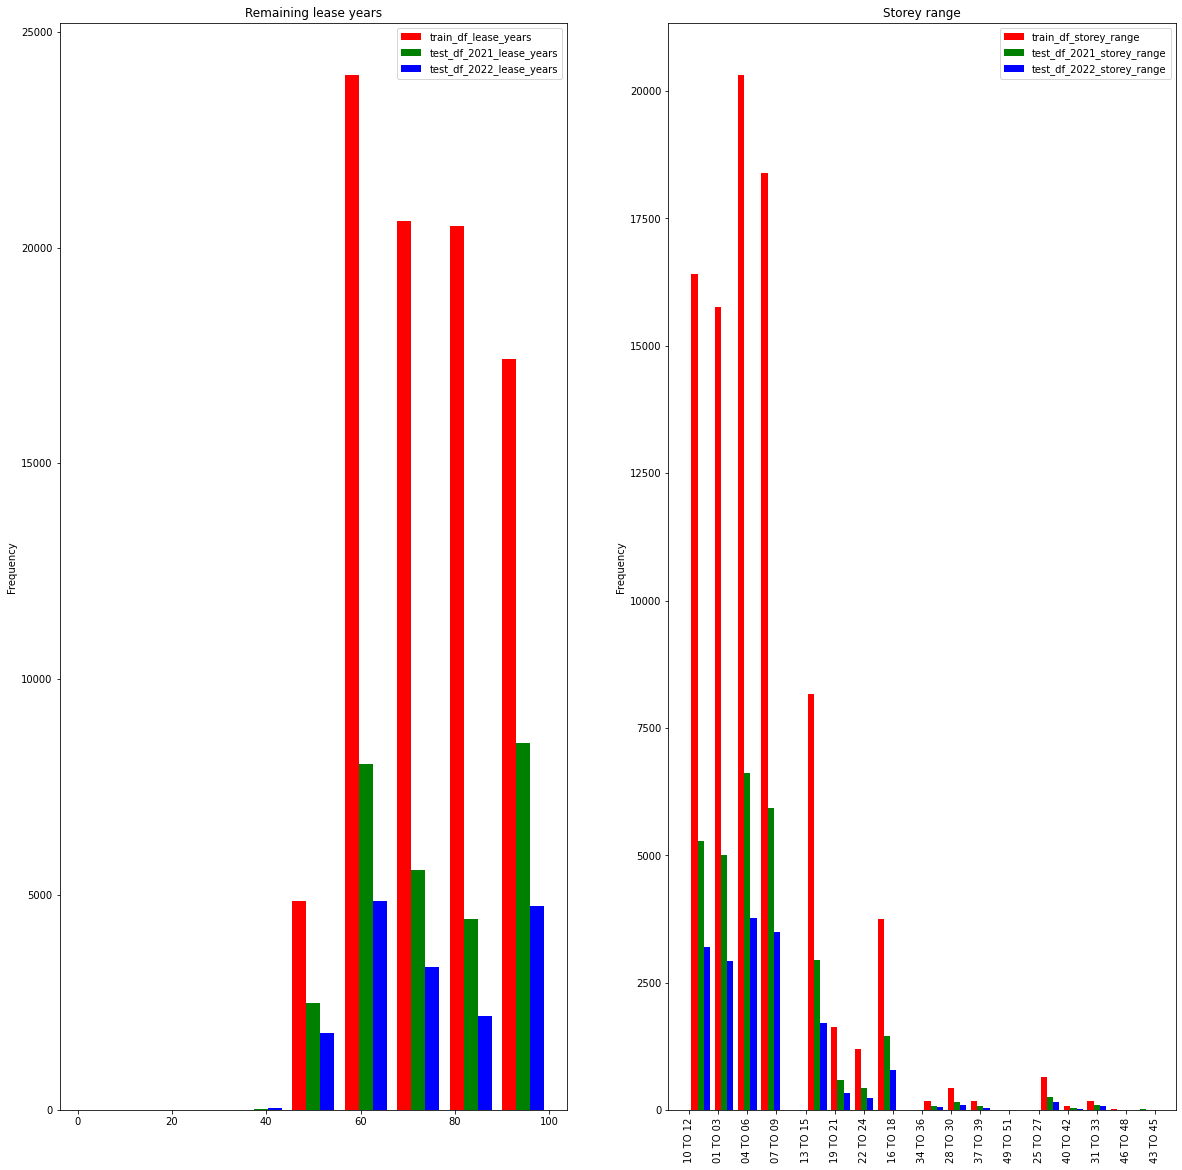

In [39]:
fig, axes =plt.subplots(1,2, figsize=(20,20))

axes[0].hist([train_df_shift["remaining_lease_years"], test_df_2021_shift["remaining_lease_years"],test_df_2022_shift["remaining_lease_years"]],bins = np.linspace(0, 100, num=10), histtype='bar', color =['red', 'green', 'blue'], label=['train_df_lease_years', 'test_df_2021_lease_years', 'test_df_2022_lease_years'],rwidth=0.8)
axes[0].legend(loc='upper right')
axes[0].set_title('Remaining lease years')
axes[0].set_ylabel('Frequency')

axes[1].hist([train_df_shift["storey_range"], test_df_2021_shift["storey_range"],test_df_2022_shift["storey_range"]],bins = 20, histtype='bar', color =['red', 'green', 'blue'], label=['train_df_storey_range', 'test_df_2021_storey_range', 'test_df_2022_storey_range'],rwidth=0.8)
axes[1].legend(loc='upper right')
axes[1].set_title('Storey range')
axes[1].set_ylabel('Frequency')

plt.xticks(rotation=90)
plt.show()

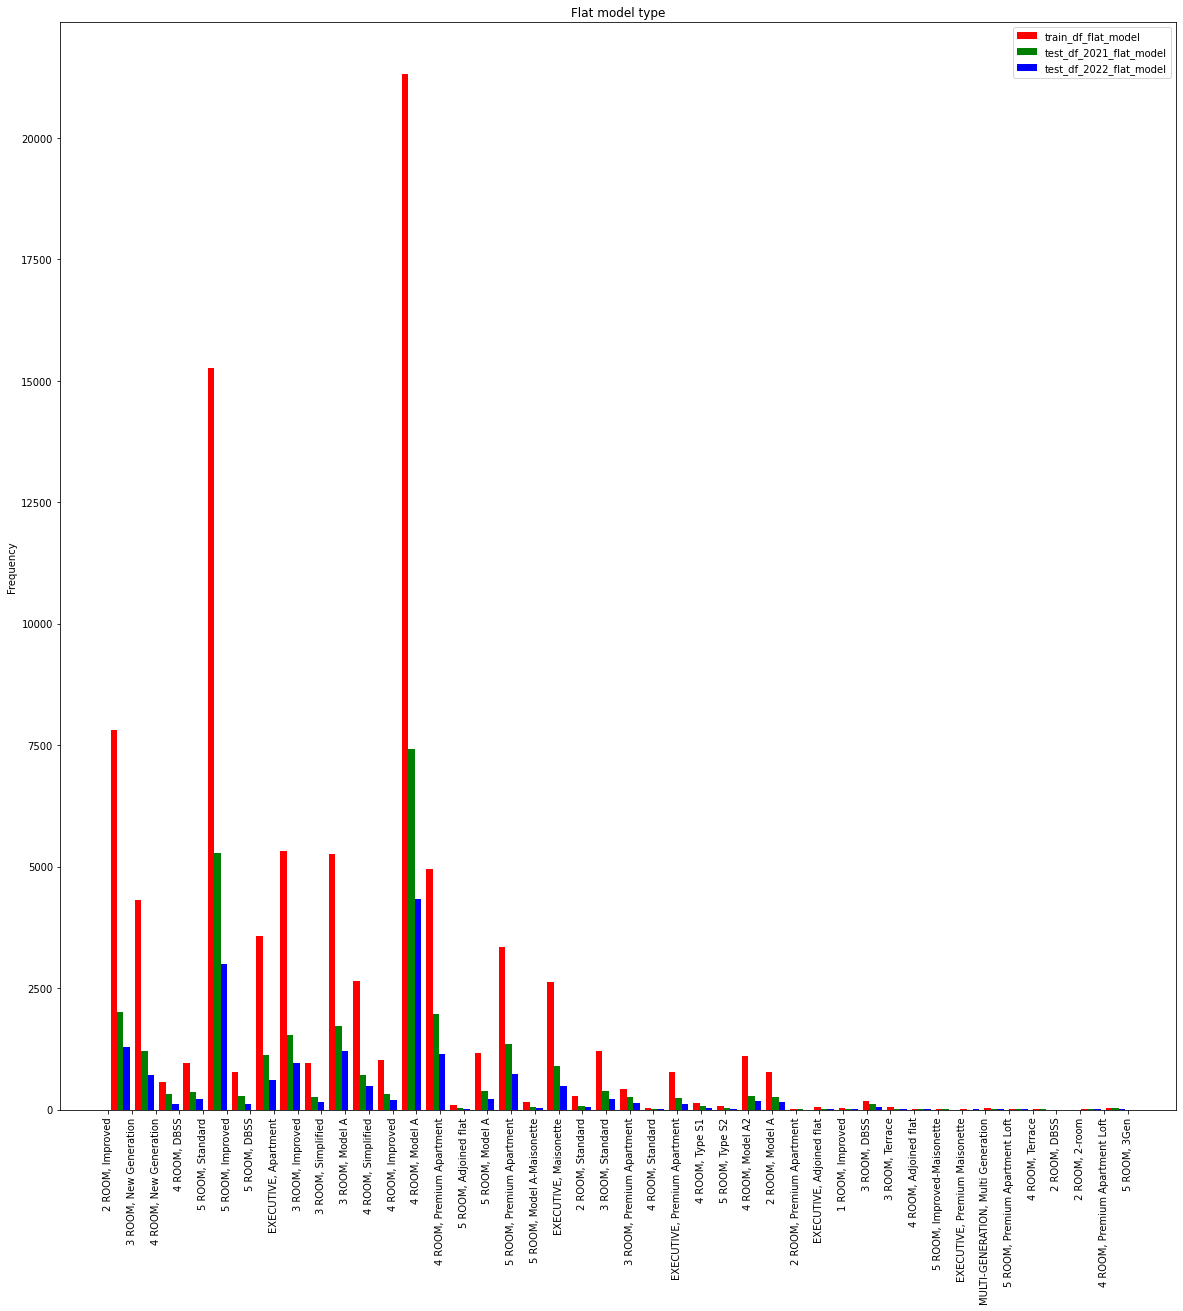

In [40]:
fig, axes =plt.subplots(1, figsize=(20,20))
axes.hist([train_df_shift["flat_model_type"], test_df_2021_shift["flat_model_type"],test_df_2022_shift["flat_model_type"]],bins = test_df_2021_shift["flat_model_type"].nunique(), histtype='bar', color =['red', 'green', 'blue'], label=['train_df_flat_model', 'test_df_2021_flat_model', 'test_df_2022_flat_model'],rwidth=0.8)
axes.legend(loc='upper right')
axes.set_title('Flat model type')
axes.set_ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

## Question 3C 

#### Which variable showed the largest covariate/label shift that might have led to the drop in model performance as seen in 3b? 

**From the histogram plot, the Month has the largest distribution shift within the train and test dataset which could be the reason for the drop in R^2 values**

**The easiest way would be to drop the features which are being classifed as drifiting, however this might result in a loss of information**

## Question 3D & 3E

In [41]:
"""
Implementation of recursive feature elimination algorithm for neural networks.

Recursive feature elimination (RFE) is a feature selection method that removes unnecessary features from the inputs. 
It can also shed some insights on how much each feature contributes to the prediction task.

The algorithm starts by removing one input feature whose removal leads to the minimum drop (or maximum improvement) in performance. 
- Given k features, to determine which of the k features will cause the minimum drop / maximum increase when that feature is removed, you will have to perform k experiments. After removing that feature, k-1 features will be left and you will have to perform k-1 experiments to determine the next feature to remove.
    - In the case removing a feature leads to an improvement from the baseline (all features used), that feature is likely not useful since removing it actually helped the model to perform better.
    - There will also be cases when all subsets with k-1 features do not do better than the baseline model. In that case, it is likely that all features are useful. You can get a sense of which are more useful than others by looking at the increase in error that occurs when the feature is removed.

This procedure is repeated recursively on the reduced input set until the optimal number of input features is reached. 
- The feature removal goes on until either 1 feature is left, or the model performance does not improve from the previous best (e.g. when there are 7 features left, if none of the 7 experiments performed does better than the best performance of the model with 8 features, the RFE algorithm terminates).
- The condition to stop the recursive process once all (k-1)-features models do worse than the best k-features model was added to make the algorithm terminate earlier so that you don't have to run too many iterations. Also, if the condition happens, then subsequent search is likely to be fruitless (it's always possible for the contrary to happen, but the chances are low and it's usually not worth the additional time).

Each model should use a different subset of features and they are trained independently. There is no loading of weights from any previous models.


In the code below, a boolean mask `vec` is used to keep track of which features to select during the iteration. 

You need to place your model training code into the 'train_model' function and have it return the validation loss.

Look out for the comments labelled 'TODO'.

"""

import time
start = time.time()

num_features = 9

vec = [1 for i in range(num_features)]
best_loss = 1e15
new_best_loss = 1e14
which_iter = ''

all_losses = [] # should be len 9,8,7,...


def train_model(feature_mask):
    """
    Given a boolean mask (feature_mask), select the features accordingly, train the model and return the validation loss.
    """
    
    feature_mask_string = ''.join([str(i) for i in feature_mask])
    
    # TODO: define the input layer here (your code from Q2)
    month_num_categories = df["month"].nunique()
    flat_model_type_num_categories = df["flat_model_type"].nunique()
    storey_range_num_categories = df["storey_range"].nunique()


    #Integer categorical features
    month_embedded = Q2_encode_categorical_feature(month, "month",Q2_train_ds, False, month_num_categories, divisor)
    #String categorical features
    flat_model_type_embedded = Q2_encode_categorical_feature(flat_model_type, "flat_model_type",Q2_train_ds, True, flat_model_type_num_categories, divisor)
    storey_range_embedded = Q2_encode_categorical_feature(storey_range, "storey_range",Q2_train_ds, True, storey_range_num_categories, divisor)
    
    #Numerical features
    dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", Q2_train_ds)
    dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", Q2_train_ds)
    degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", Q2_train_ds)
    eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", Q2_train_ds)
    remaining_lease_year_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", Q2_train_ds)
    floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm,"floor_area_sqm", Q2_train_ds)
    
    all_features_input = [
                        month_embedded,
                        storey_range_embedded,
                        flat_model_type_embedded,
                        floor_area_sqm_encoded,
                        remaining_lease_year_encoded,
                        degree_centrality_encoded,
                        eigenvector_centrality_encoded,
                        dist_to_nearest_stn_encoded,
                        dist_to_dhoby_encoded
                    ]
            
    selected_inputs = []
    print('going through feature_mask', feature_mask)
    for i,j in zip(all_features_input, feature_mask):
        if j == 1:
            selected_inputs.append(i)
            print(i)
        else:
            print('Skipping', i)

    all_features = layers.concatenate(selected_inputs)
    
    
    # TODO: Complete the rest of the architecture + training code and retrieve the training history
    Q2D_model_history = {}
    hidden_layer = layers.Dense(units=hidden_units, activation ="linear")(all_features)
    output = layers.Dense(1, activation="linear")(hidden_layer)
    Q2D_model = keras.Model(all_inputs, output)
    Q2D_model.compile(optimizer=Q2_optimizer, loss= "mse",metrics=[r2])
    
    # Train on the non-test split ( 2020 and before hence using train_ds instead of Q2_train_ds)
    Q2D_model_history["model"] = Q2D_model.fit(train_ds, epochs=50, validation_data = Q2_val_ds, verbose=1)
    
    
    val_loss_hx = square_roots(Q2D_model_history["model"].history["val_loss"]) # NOTE: You can use RMSE if you find it easier to interpret.
    val_loss_min = min(val_loss_hx)
    
    return val_loss_min


## RFE starts here 

while sum(vec) > 0 and best_loss > new_best_loss:
    
    print('vec', vec)

    best_loss = new_best_loss
    new_min_loss_flag = False
    
    losses_from_same_vec = []
    
    for ix, i in enumerate(vec):
        
        print('ix', ix, 'i', i)
        
        if i == 0:
            continue # if the feature is off, no need to do anything, go to next position
        else:
            temp_vec = vec[:]
            temp_vec[ix] = 0 # turn off the feature
            print('updated temp_vec', temp_vec)
            
            loss = train_model(temp_vec)
            losses_from_same_vec.append(loss)
            
            if loss < new_best_loss:
                new_best_loss = loss
                which_iter = 'len ' + str(sum(vec)) + ', ix ' + str(ix)
                print('new min loss:', which_iter)
                new_min_loss_flag = True
                min_loss_vec = temp_vec[:]

            tf.keras.backend.clear_session()
            print('session cleared!\n')
                
    
    all_losses.append(losses_from_same_vec)
    
    # After going through the vec once, update vec if new min loss    
    if new_min_loss_flag:
        vec = min_loss_vec
    
    # else case means no new min loss, the latter while loop condition will cause it to terminate 
    print(time.time() - start, 'seconds elapsed')
    print()

print(all_losses)


vec [1, 1, 1, 1, 1, 1, 1, 1, 1]
ix 0 i 1
updated temp_vec [0, 1, 1, 1, 1, 1, 1, 1, 1]
going through feature_mask [0, 1, 1, 1, 1, 1, 1, 1, 1]
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='flatten_6/Reshape:0', description="created by layer 'flatten_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), name='flatten_8/Reshape:0', description="created by layer 'flatten_8'")
KerasTensor(type_spec=TensorSpec(shape=(None, 22), dtype=tf.float32, name=None), name='flatten_7/Reshape:0', description="created by layer 'flatten_7'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_5/truediv:0', description="created by layer 'normalization_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_4/truediv:0', description="created by layer 'normalization_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float3

c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


342/342 [==============================] - 6s 14ms/step - loss: 20239697920.0000 - r2: 0.1398 - val_loss: 6481441792.0000 - val_r2: 0.7281
Epoch 2/50
342/342 [==============================] - 5s 14ms/step - loss: 6072357376.0000 - r2: 0.7423 - val_loss: 5537464832.0000 - val_r2: 0.7660
Epoch 3/50
342/342 [==============================] - 5s 14ms/step - loss: 5325361152.0000 - r2: 0.7740 - val_loss: 5090524160.0000 - val_r2: 0.7837
Epoch 4/50
342/342 [==============================] - 5s 12ms/step - loss: 4874365440.0000 - r2: 0.7931 - val_loss: 4581555200.0000 - val_r2: 0.8072
Epoch 5/50
342/342 [==============================] - 5s 12ms/step - loss: 4549678080.0000 - r2: 0.8070 - val_loss: 4387513856.0000 - val_r2: 0.8143
Epoch 6/50
342/342 [==============================] - 5s 12ms/step - loss: 4299068416.0000 - r2: 0.8172 - val_loss: 4183266816.0000 - val_r2: 0.8204
Epoch 7/50
342/342 [==============================] - 5s 12ms/step - loss: 4117034240.0000 - r2: 0.8250 - val_loss: 

In [42]:
best_feature_subset = []
input = [
                    "month",
                    "storey_range",
                    "flat_model_type",
                    "floor_area_sqm",
                    "remaining_lease_year",
                    "degree_centrality",
                    "eigenvector_centrality",
                    "dist_to_nearest_stn",
                    "dist_to_dhoby"
                    ]

for i in range(len(vec)):
    if vec[i] == 1:
        best_feature_subset.append(input[i])

print(best_feature_subset)
        

['month', 'storey_range', 'flat_model_type', 'floor_area_sqm', 'remaining_lease_year', 'degree_centrality', 'dist_to_nearest_stn', 'dist_to_dhoby']


**Best feature subset is month, storey_range, flat_model_type, floor_area_sqm, remaining_lease_year, degree_centrality, dist_to_nearest_stn and dist_to_dhoby**

Identify if there is any concept shift

**Please answer**

## DISCUSSION POINTS